# Лабораторная работа №4 “Нейронные сети”

In [467]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import optimize
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd
import copy

## Task 1

Набор данных ex4data1.mat (такой же, как в лабораторной работе №2)
представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор
содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель
представляет собой значение яркости (вещественное число). Каждое
изображение сохранено в виде вектора из 400 элементов. В результате
загрузки набора данных должна быть получена матрица 5000x400. Далее
расположены метки классов изображений от 1 до 9 (соответствуют цифрам
от 1 до 9), а также 10 (соответствует цифре 0).

1. Загрузите данные ex4data1.mat из файла.

In [2]:
task1_file_name = "Data\Lab 4\ex4data1.mat"
mat = loadmat(task1_file_name)  # load mat-file
X = mat['X']
y = mat['y']

In [242]:
y.shape

(5000, 1)

2. Загрузите веса нейронной сети из файла ex4weights.mat, который
содержит две матрицы Θ<sup>(1)</sup>(25, 401) и Θ<sup>(2)</sup>(10, 26). Какова структура полученной нейронной сети?

In [411]:
task1_weights_file_name = "Data\Lab 4\ex4weights.mat"
mat = loadmat(task1_weights_file_name)  # load mat-file
Theta1 = mat['Theta1']
Theta2 = mat['Theta2']

3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации.

In [260]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))

In [372]:
def perceptron(t, x, func, is_last=False):
    aggregated_data = np.dot(x, t.T)
    if is_last:
        return func(aggregated_data)
    return np.hstack((np.ones((x.shape[0], 1)), func(aggregated_data)))

In [392]:
def feedforward(x, layers_weights, func):
    layers_output = [x]
    for num_layer, layer_weights in enumerate(layers_weights):
        layer_output = perceptron(layer_weights, layers_output[-1], func, is_last=(num_layer+1==len(layers_weights)))
        layers_output.append(layer_output)
    return layers_output

4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [412]:
x = np.hstack((np.ones((X.shape[0], 1)), X))
pred = np.argmax(feedforward(x, [Theta1, Theta2], sigmoid)[-1], axis = 1) + 1 
np.mean(pred.flatten() == y.flatten()) * 100

97.52

При классификации данных изображений с помощью логистической регрессии удалось достигнуть точности 94.76% против 94.22% при использовании сети прямого распространения. Однако, логистическая регрессия работала 15 минут, против нескольких секунд при использовании сети прямого распространения.

5. Перекодируйте исходные метки классов по схеме one-hot.

In [55]:
k = 10
class_matrix = np.eye(k)
class_model = {}
for i in range(k):
    class_model[i+1] = class_matrix[:, i].reshape(1, k)

In [56]:
class_model

{1: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 2: array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 3: array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 4: array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 5: array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 6: array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
 7: array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]),
 8: array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]),
 9: array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 10: array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])}

In [269]:
y_in_hot = np.zeros((y.shape[0], k))
for i in range(y.shape[0]):
    y_in_hot[i, :] = class_model[y[i,0]]
y_in_hot = y_in_hot.T

6. Реализуйте функцию стоимости для данной нейронной сети.

In [426]:
def lost_func(x, layers_weights, y):
    m = x.shape[0]
    h = feedforward(x, layers_weights, sigmoid)[-1]
    return (-1 / m) * np.sum(np.dot(y, np.log(h))+np.dot(1 - y, np.log(1 - h)))

In [450]:
def cost(x, layers_weights, y):
    m = x.shape[0]
    h = feedforward(x, layers_weights, sigmoid)[-1]
    y_log_h = np.dot(y, np.log(h))
    m_y_log_h = np.dot(1 - y, np.log(1 - h))
    
    return np.sum(np.min(-y_log_h - m_y_log_h, axis=1)) / m

In [451]:
cost(x, [Theta1, Theta2], y_in_hot)

0.28762916516131887

7. Добавьте L2-регуляризацию в функцию стоимости.

In [498]:
def lost_func_with_reg(x, layers_weights, y, reg_koef):
    m = x.shape[0]
    cost_value = cost(x, layers_weights, y)
    regularization_value = 0
    
    for layer_weights in layers_weights:
        regularization_value += np.sum(np.square(layer_weights))
    
    return cost_value + reg_koef * regularization_value / (2 * m)

In [501]:
lost_func_with_reg(x, [Theta1, Theta2], y_in_hot, 0.0)

0.28762916516131887

8. Реализуйте функцию вычисления производной для функции активации

In [431]:
d_sigmoid = lambda z: z * (1 - z)

9. Инициализируйте веса небольшими случайными числами.

In [493]:
# (b - a) * random_sample() + a [-1; 1)
T1 = 2 * np.random.random_sample(Theta1.shape) - 1
T2 = 2 * np.random.random_sample(Theta2.shape) - 1

10.Реализуйте алгоритм обратного распространения ошибки для данной
конфигурации сети

In [439]:
def backpropagation(x, y, layers_weights, reg_koef, func):
    m = x.shape[0]
    layers_output = feedforward(x, layers_weights, func)
    count_layers = len(layers_weights)
    
    grad = (layers_output[-1] - y.T)
    new_layers_weights = []
    for layer_num in reversed(range(count_layers)): 
        theta_reg = reg_koef * np.hstack((np.zeros((layers_weights[layer_num].shape[0], 1)), layers_weights[layer_num][:, 1:])).T
        if not new_layers_weights:
            new_theta = (theta_reg + np.dot(layers_output[layer_num].T, grad)) / m
        else:
            new_theta = (theta_reg + np.dot(layers_output[layer_num].T, (np.dot(layers_weights[layer_num+1].T, grad.T) * d_sigmoid(layers_output[layer_num+1]).T).T)[:,1:]) / m
        new_layers_weights.append(new_theta.T)
    new_layers_weights.reverse()
    
    return new_layers_weights

11.Для того, чтобы удостоверится в правильности вычисленных значений
градиентов используйте метод проверки градиента с параметром ε = 10<sup>-4</sup>

12.Добавьте L2-регуляризацию в процесс вычисления градиентов.

13.Проверьте полученные значения градиента.

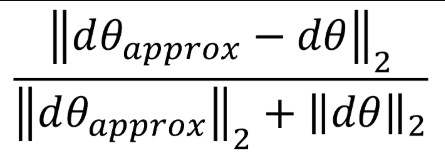

In [486]:
def gradient_check(x, y, layers_weights,  reg_koef=10.0, epsilon=1e-4):
    grad_approx = []
    for layer_num in range(len(layers_weights)):
        layer_weights = layers_weights[layer_num]
        print(layer_weights.shape)
        for i in range(layer_weights.shape[0]):
            for j in range(layer_weights.shape[1]):
                theta_m = np.copy(layer_weights) 
                theta_m[i, j] -= epsilon
                theta_p = np.copy(layer_weights) 
                theta_p[i, j] += epsilon
                temp_theta_m = copy.deepcopy(layers_weights)
                temp_theta_m[layer_num] = theta_m
                temp_theta_p = copy.deepcopy(layers_weights)
                temp_theta_p[layer_num] = theta_p
                J_plus = lost_func_with_reg(x, temp_theta_p, y, reg_koef)
                J_minus = lost_func_with_reg(x, temp_theta_m, y, reg_koef)
                grad_approx.append((J_plus - J_minus) / (2 * epsilon))
    return grad_approx

In [499]:
grad_approx = gradient_check(x, y_in_hot, theta_new, 1.0)

(25, 401)
(10, 26)


In [502]:
grad_approx - theta_new_conc

array([1.1448005 , 0.31384766, 0.64103814, ..., 0.025331  , 0.67264159,
       1.23376825])

In [500]:
grad_approx = np.array(grad_approx)
theta_new_conc = np.concatenate((theta_new[0].flatten(), theta_new[1].flatten()))
diff = np.linalg.norm(grad_approx - theta_new_conc)/(np.linalg.norm(grad_approx) + np.linalg.norm(theta_new_conc))
diff

0.9996392726477744

14.Обучите нейронную сеть с использованием градиентного спуска или
других более эффективных методов оптимизации.

In [349]:
def train(x, y, layers_weights, alpha, reg_koef, iterations=100, func=sigmoid):
    for i in range(0, iterations):
        new_layers_weights = backpropagation(x, y, layers_weights, reg_koef, func)
        for i in range(len(layers_weights)):
            layers_weights[i] -= alpha * new_layers_weights[i]
    return layers_weights

In [494]:
theta_new = train(x, y_in_hot, [T1, T2], 1.0, 1.0, 1000)

15.Вычислите процент правильных классификаций на обучающей
выборке.

In [441]:
result = feedforward(x, theta_new, sigmoid)[-1]
pred = np.argmax(result, axis = 1) + 1
np.mean(pred.flatten() == y.flatten()) * 100

94.22

16.Визуализируйте скрытый слой обученной сети.

In [401]:
def visualize_hidden_layer(reg_koef):
    theta1_v, theta2_v = train(x, y_in_hot, theta_new, 1, reg_koef, 1000)
    theta_v = theta1_v[:, 1:]
    fig, ax = plt.subplots(5, 5,figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            ax[i,j].imshow(theta_v[i * 2 + j].reshape((20,20), order = 'F'))          
            ax[i,j].axis('off')

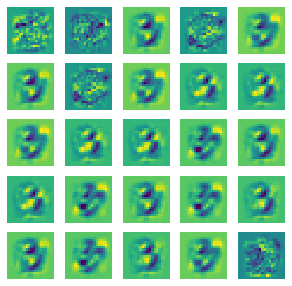

In [404]:
visualize_hidden_layer(0)

17.Подберите параметр регуляризации. Как меняются изображения на
скрытом слое в зависимости от данного параметра?

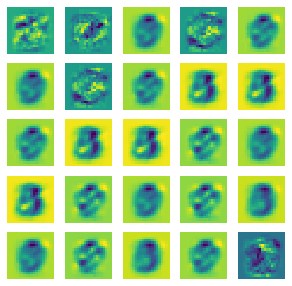

In [403]:
visualize_hidden_layer(1)

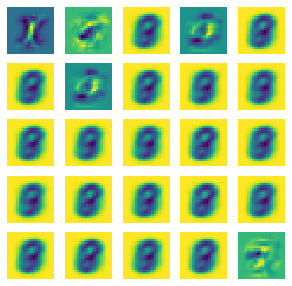

In [406]:
visualize_hidden_layer(5)

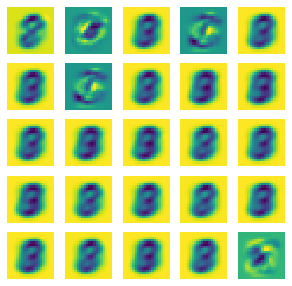

In [402]:
visualize_hidden_layer(10)

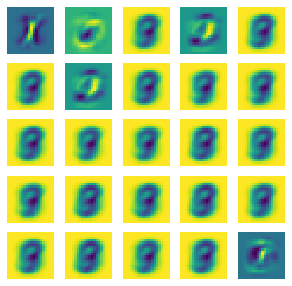

In [407]:
visualize_hidden_layer(15)

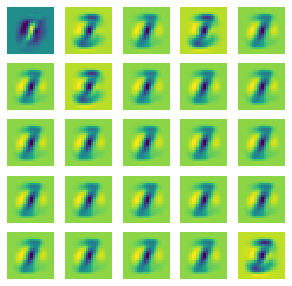

In [405]:
visualize_hidden_layer(100)